In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset
from dataclasses import dataclass, field, fields
from typing import List, Dict, Tuple
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader
from torch.utils.tensorboard.writer import SummaryWriter
from copy import deepcopy
import os





@dataclass
class Configs:
    
    #...general params:
    WORKDIR : str = './'   
    DEVICE : str = 'cuda:2'
    MULTI_GPU : bool = False

    #...data params:
    DATA : str = None
    DATA_TARGET : str = '8gaussians'
    DATA_SOURCE : str = 'noise'
    DIM_INPUT : int = None
    INPUT_SHAPE : Tuple[float] = field(default_factory = lambda : (2, 1, 1))
    
    #...model params:
    MODEL : str = 'MLP'
    DIM_HIDDEN : int = 128  
    TIME_EMBEDDING : str = 'sinusoidal'
    DIM_TIME_EMB : int = 16
    NUM_LAYERS : int = 3
    DROPOUT : float = 0.0
    ACTIVATION : str = 'ReLU'

    #...training params:
    BATCH_SIZE : int = 128
    DATA_SPLIT_FRACS : List[float] = field(default_factory = lambda : [1.0, 0.0, 0.0])  # train / val / test 
    EPOCHS: int = 30
    EARLY_STOPPING : int = None
    MIN_EPOCHS : int = None 
    PRINT_EPOCHS : int = None   
    FIX_SEED : int = None  
    NUM_WORKERS : int = 0
    PIN_MEMORY: bool = False

    #...cfm params:
    DYNAMICS : str = 'CondFlowMatch'
    SIGMA : float = 0.001
    AUGMENTED : bool = False
    T0 : float = 0.0
    T1 : float = 1.0

    #...optimization & scheduler params:
    OPTIMIZER: str = 'Adam'
    LR : float = 1e-4
    WEIGHT_DECAY : float = 0.0
    OPTIMIZER_BETAS : List[float] = field(default_factory = lambda : [0.9, 0.999])
    OPTIMIZER_EPS : float = 1e-8
    OPTIMIZER_AMSGRAD : bool = False
    GRADIENT_CLIP : float = None
    SCHEDULER: str = None
    SCHEDULER_T_MAX: int = None
    SCHEDULER_ETA_MIN: float = None
    SCHEDULER_GAMMA: float = None
    SCHEDULER_STEP_SIZE: int = None

    #...generation pipeline params:
    SAMPLER : str = 'NeuralODE'
    SOLVER : str = 'euler'
    NUM_SAMPLING_STEPS : int = 100
    SENSITIVITY : str = 'adjoint'
    ATOL : float = None
    RTOL : float = None
    NUM_GEN_SAMPLES: int = 10 


    def __post_init__(self):
        self.DATA = self.DATA_SOURCE + '_to_' + self.DATA_TARGET
        self.DIM_INPUT = np.prod(self.INPUT_SHAPE)
        if self.MULTI_GPU: self.DEVICE = 'cuda:0'


In [2]:
from cmb.data.gaussians import EightGaussiansDataClass
from cmb.data.utils import DefineDataloader

conf = Configs()
conf.WORKDIR = '../results/gauss_test'

gauss = EightGaussiansDataClass(conf)
dataloader = DefineDataloader(gauss)

INFO: building dataloaders...
INFO: train/val/test split ratios: 1.0/0.0/0.0
INFO: train size: 8000, validation size: 0, testing sizes: 0


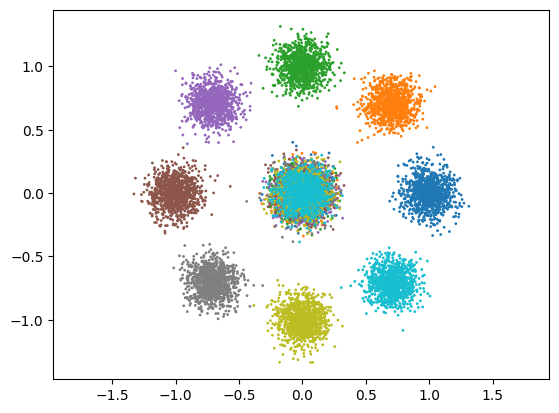

In [3]:
gauss.target.shape
plt.scatter(gauss.target[:, 0], gauss.target[:, 1], s=1, c=gauss.context, cmap = 'tab10')
plt.scatter(gauss.source[:, 0], gauss.source[:, 1], s=1, c=gauss.context, cmap = 'tab10')
plt.axis('equal')
plt.show()



In [4]:
from cmb.dynamics.cfm import ConditionalFlowMatching
from cmb.models.architectures.deep_nets import MLP
from cmb.models.trainers import CFMTrainer

dynamics = ConditionalFlowMatching(conf)
mlp = MLP(conf)
model = CFMTrainer(dynamics, mlp, gauss)
model.train()

2024-07-22 16:54:13.643013: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-22 16:54:13.687264: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-22 16:54:13.688250: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 16:54:14.413759: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
number of training parameters: 17666
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 1.0/0.0/0.0
INFO: train size: 8000, validation size: 0, testing sizes: 0


epochs:   0%|          | 0/30 [00:00<?, ?it/s]

RuntimeError: Tensors must have same number of dimensions: got 2 and 3